In this note I apply machine learning techniques to make the computer in skyjo smarter. 

In this noteboook I use normal machine learning using properties of a turns against the result target (score/winner) of the round/game. 

In the application to the game the algorithm then tests the possible options (actions plus card choice if applied on open card) plus the unchangable players card, pile properties and uses the best one.

The current card values of closed (20) and existing (30) mean that linear methods do not work. I could have used card mean for closed and 0 for existing. That would get many of the effects but not all since the variance of the values matters and vanish is not exactly the same as zero. 
Instead I opt in the first attempt to use the non linear algorith xgboost because it is fast and can handle non linear effects.

While for the players card in most the game it does not matter where the cards are it matters for whether the player can reduce his score by making three equal cards vanish in a row. For now I try brute force instead of having a scheme where that is more directly recorded.

First I import the needed modules. 

This notebook first mainly executes the best method from machine_learning_skyjo1 correcting the small problem found. 

In [2]:
#standard modukles
import numpy as np
import random as random
import time
import pandas as pd
#using simpleguitk for display, is not needed for computer game
#likely not needed un this notebook 
import simpleguitk as simplegui
#foor plotting 
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
#for efficient saving and loading
import pickle
#skyjp game classes and functions
from skyjo_functions2 import *
#own functions for machine learning
from ml_functions2 import *
#for machine learning
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
#time logging
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
#again tensorflow problem work before with conda install cudatoolkit, is not needed after each restart? 
#no is not enough still does not work  

2023-03-09 15:00:57.823148: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-09 15:00:57.823197: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


First I test whether a single round works. 

In [3]:
#needs the player defined
names=['alpha','beta']
nature=['computer','computer']
levels=[0,0]
scores,turns,last_player,numeric=skyjo_round(names,nature,levels,0,True,True,True) 

In works.


For now I work with two players, because it is likely easiest. Secondly, I work on a round, not a match, because while the game is the principal unit, it include some additional complications, but it seems unlikely that they influence the strategy much or at all. 

As the first step I train a predictor to predict the point differential (own points-opponents points).  I use only a subset of the feature information now. I ignore most information of the piles, besides the top most open card, which can be taken. The other information (mainly values of other played cards) is in principle useful to know which cards are still in game, but that should be a minor modification of the main strategy.  The length of the closed pile, is also related to it and is likely just a shortcut it should be possible to get it from other properties also. 
I also ignore whether cards vanish because it depends on the value of closed cards and cannot none so well as the algorithm could think when it uses all data. Also it is likely just a minor modification, although it is possible that it nt easy to find because it rather differnt form the used options. Later I will reconsider this point. 

I also ignore the round number since I expect that it is not useful at least when all player card value and the open card value is available.

I implement these choices below in an 1D arrayb with the number of columns, 1 are the used columns, 0 are not used columns.  I also create a string list, such that the collected data can be passed to a table with meaningful column names. 

In [4]:
names=['alpha','beta']
nature=['computer','computer']
levels=[0,0]
scores,turns,last_player,numeric=skyjo_round(names,nature,levels,0,True,True,True) 
print(numeric.shape)
#selected rows array
sel1=np.zeros((51))
#print the row to see whether it is what it should be 
#open card on pile
sel1[1]=1
#own card set
print(numeric[18:30,0])
sel1[18:30]=1
#other card set
print(numeric[30:42,0])
sel1[30:42]=1
#take open 
print(numeric[42])
sel1[42]=1
#discard
print(numeric[43])
sel1[43]=1
# discarded closed card
print(numeric[44])
sel1[44]=1
#id of selected player card
print(numeric[45])
sel1[45]=1
#numeric (number of open or 20 for closed) of selected player card
print(numeric[46])
sel1[46]=1
#score, differential is used as target for now both included in collection
print(numeric[49])
sel1[49]=1
print(numeric[50])
sel1[50]=1
print(sum(sel1))
print(numeric.shape)
# list of strings which will be pandas header
columns=['open_pile_card']
for i in range(12):
    columns.append('own_cards_'+str(i))
for i in range(12):
    columns.append('other_player_cards_'+str(i))    
columns.append('action_take_open')
columns.append('action_discard')
columns.append('discard_value')
columns.append('id_player_card')
columns.append('numeric_player_card')            
columns.append('score_self')
columns.append('score_other')
columns.append('round')
print(columns)
print(len(columns))
#create copy which to be used fields  score not
sel2=np.copy(sel1)
sel2[48:51]=0
np.savetxt("xgb_model1_column2.txt",sel2)
print(sum(sel2))
print(sum(sel1))
print(sel2)
print(sel1)
print(columns[0:30])
print(columns[28])

(51, 31)
[20 20 20 20 20 20 11 -2 20 20 20 20]
[20 -1 20 20 20 20  5 20 20 20 20 20]
[0 0 0 0 0 1 1 1 1 0 1 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 0 1 0 0 1]
[0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0]
[ 0  3 11 12 12 30 30 30 30 11 30 -1  4 30  4  6 -2 30 30 11 30 30 30 12
  5  0  8 30 12  3 30]
[ 5  8  7  1  9 10  8  7  3  3  9  9 11  1  0  4  2  6  0  5  3  3  3  0
  1  2  9  7  8 11  5]
[20 20 -2 -1 20 20 20 20 20 20  1 20 20 12 20 20 20  5  5 20  6 11 11 20
 20 20  5 11  2 20  0]
[106  53 106  53 106  53 106  53 106  53 106  53 106  53 106  53 106  53
 106  53 106  53 106  53 106  53 106  53 106  53 106]
[ 53 106  53 106  53 106  53 106  53 106  53 106  53 106  53 106  53 106
  53 106  53 106  53 106  53 106  53 106  53 106  53]
32.0
(51, 31)
['open_pile_card', 'own_cards_0', 'own_cards_1', 'own_cards_2', 'own_cards_3', 'own_cards_4', 'own_cards_5', 'own_cards_6', 'own_cards_7', 'own_cards_8', 'own_cards_9', 'own_cards_10', 'own_cards_11', 'other_player_cards_0', 'other

In [5]:
#now withjthout taken card id for engering use 
sel1b=np.zeros((51))
#print the row to see whether it is what it should be 
#open card on pile
sel1b[1]=1
#own card set
print(numeric[18:30,0])
sel1b[18:30]=1
#other card set
print(numeric[30:42,0])
sel1b[30:42]=1
#take open 
print(numeric[42])
sel1b[42]=1
#discard
print(numeric[43])
sel1b[43]=1
# discarded closed card
print(numeric[44])
sel1b[44]=1
#id of selected player card not anymore used 
#print(numeric[45])
#sel1b[45]=1
#numeric (number of open or 20 for closed) of selected player card
print(numeric[46])
sel1b[46]=1
#score, differential is used as target for now both included in collection
print(numeric[49])
sel1b[49]=1
print(numeric[50])
sel1b[50]=1
print(sum(sel1b))
print(numeric.shape)
# list of strings which will be pandas header
columnsb=['open_pile_card']
for i in range(12):
    columnsb.append('own_cards_'+str(i))
for i in range(12):
    columnsb.append('other_player_cards_'+str(i))    
columnsb.append('action_take_open')
columnsb.append('action_discard')
columnsb.append('discard_value')
# not anymore used columnsb.append('id_player_card')
columnsb.append('numeric_player_card')            
columnsb.append('score_self')
columnsb.append('score_other')
columnsb.append('round')
print(columnsb)
print(len(columnsb))
#create copy which to be used fields  score not
sel2b=np.copy(sel1b)
sel2b[49:51]=0
np.savetxt("xgb_model2_column2.txt",sel2b)
print(sum(sel2b))
print(sum(sel1b))
print(sel2b)
print(sel1b)
print(columnsb[0:29])

[20 20 20 20 20 20 11 -2 20 20 20 20]
[20 -1 20 20 20 20  5 20 20 20 20 20]
[0 0 0 0 0 1 1 1 1 0 1 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 0 1 0 0 1]
[0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0]
[ 0  3 11 12 12 30 30 30 30 11 30 -1  4 30  4  6 -2 30 30 11 30 30 30 12
  5  0  8 30 12  3 30]
[20 20 -2 -1 20 20 20 20 20 20  1 20 20 12 20 20 20  5  5 20  6 11 11 20
 20 20  5 11  2 20  0]
[106  53 106  53 106  53 106  53 106  53 106  53 106  53 106  53 106  53
 106  53 106  53 106  53 106  53 106  53 106  53 106]
[ 53 106  53 106  53 106  53 106  53 106  53 106  53 106  53 106  53 106
  53 106  53 106  53 106  53 106  53 106  53 106  53]
31.0
(51, 31)
['open_pile_card', 'own_cards_0', 'own_cards_1', 'own_cards_2', 'own_cards_3', 'own_cards_4', 'own_cards_5', 'own_cards_6', 'own_cards_7', 'own_cards_8', 'own_cards_9', 'own_cards_10', 'own_cards_11', 'other_player_cards_0', 'other_player_cards_1', 'other_player_cards_2', 'other_player_cards_3', 'other_player_cards_4', 'other_player_c

Thus in total it are 30 features and 1 target. The target is currently still in two different columns. 

One round is clearly not enough to train, not only because of the length of typically 32 data collections (turns), but also because the data is similar in the different turns. 
Thus, the data from many rounds needs to be collected. 


Below a check I check the function which collected many rounds.

In [26]:
start_time=time.time()
df=round_for_ml(names,nature,levels,sel1,3000,columns)
stop_time=time.time()
print(f"running time was {round(stop_time-start_time,4)} seconds")
print(df)

case 0
case 4
case 8
case 12
case 16
case 20
case 24
case 28
case 32
case 36
case 40
case 44
case 48
case 52
case 56
case 60
case 64
case 68
case 72
case 76
case 80
case 84
case 88
case 92
case 96
case 100
case 104
case 108
case 112
case 116
case 120
case 124
case 128
case 132
case 136
case 140
case 144
case 148
case 152
case 156
case 160
case 164
case 168
case 172
case 176
case 180
case 184
case 188
case 192
case 196
case 200
case 204
case 208
case 212
case 216
case 220
case 224
case 228
case 232
case 236
case 240
case 244
case 248
case 252
case 256
case 260
case 264
case 268
case 272
case 276
case 280
case 284
case 288
case 292
case 296
case 300
case 304
case 308
case 312
case 316
case 320
case 324
case 328
case 332
case 336
case 340
case 344
case 348
case 352
case 356
case 360
case 364
case 368
case 372
case 376
case 380
case 384
case 388
case 392
case 396
case 400
case 404
case 408
case 412
case 416
case 420
case 424
case 428
case 432
case 436
case 440
case 444
case 448
case 452
ca

That was just for checking whether it works, because using each turn is less efficient than using a subset.

Now I check below whether the splitting required for it still works.

In [31]:
df=pd.read_pickle('level0_10000.pkl')
feature_train,feature_test,feature_valid,target_train,target_test,target_valid=split_test(df.iloc[:,0:31],df.score_self-df.score_other,df.loc[:,'round'],0.5,0.8)
print(feature_train.shape,feature_test.shape,feature_valid.shape)

165074
165087
264118
264123
(165087, 31) (99036, 31) (66024, 31)


It works. 

Now  I am checking the other mode which only puts out one turn per game. This one is used. 

In [47]:
start_time=time.time()
df=round_for_ml_sel(names,nature,levels,sel1,3000,columns)
df.to_pickle('level_rand_v2_0_3000_0.pkl')
stop_time=time.time()
print(f"calculation needed {round(stop_time-start_time,4)} seconds")
print(df)

case 0
case 1000
case 2000
number of rows is 3000
calculation needed 5.0827 seconds
      open_pile_card  own_cards_0  own_cards_1  own_cards_2  own_cards_3  \
0                  4            7            1           -2            3   
1                 -1           10            4            1            5   
2                  9            8            5           10            3   
3                  6            9            0            4            9   
4                  0           10           20           -2            6   
...              ...          ...          ...          ...          ...   
2995              -1            0           20           20           20   
2996              11           20            5            8            9   
2997               4            1            6            8           11   
2998               5           20           10           20           20   
2999               7            1           20            1           20   

   

Works in the test case. 

I now test the split function for it. 

In [36]:
feature_train,feature_test,feature_valid,target_train,target_test,target_valid=split_test(df.iloc[:,0:31],df.score_self-df.score_other,df.loc[:,'round'],0.5,0.8)
print(feature_train.shape,feature_test.shape,target_test.shape)

1500
1500
2400
2400
(1500, 31) (900, 31) (900,)


Now I am generating 3 million rows of data in pieces of 0.6 million rows since that is easily possible at once. 

In [54]:
start_time=time.time()
df=round_for_ml_sel(names,nature,levels,sel1,600000,columns)
df.to_pickle('level_rand_v2_0_600000_4.pkl')
stop_time=time.time()
print(f"calculation needed {round(stop_time-start_time,4)} seconds")

case 0
case 1000
case 2000
case 3000
case 4000
case 5000
case 6000
case 7000
case 8000
case 9000
case 10000
case 11000
case 12000
case 13000
case 14000
case 15000
case 16000
case 17000
case 18000
case 19000
case 20000
case 21000
case 22000
case 23000
case 24000
case 25000
case 26000
case 27000
case 28000
case 29000
case 30000
case 31000
case 32000
case 33000
case 34000
case 35000
case 36000
case 37000
case 38000
case 39000
case 40000
case 41000
case 42000
case 43000
case 44000
case 45000
case 46000
case 47000
case 48000
case 49000
case 50000
case 51000
case 52000
case 53000
case 54000
case 55000
case 56000
case 57000
case 58000
case 59000
case 60000
case 61000
case 62000
case 63000
case 64000
case 65000
case 66000
case 67000
case 68000
case 69000
case 70000
case 71000
case 72000
case 73000
case 74000
case 75000
case 76000
case 77000
case 78000
case 79000
case 80000
case 81000
case 82000
case 83000
case 84000
case 85000
case 86000
case 87000
case 88000
case 89000
case 90000
case 91000
c

Further ideas. It is impossible that xgbboost consider and will ever consider all options, it will stay approximate. 
How important is vanishing event? Could pass marker for it in the features would need to change turn function and further up also. 

Could also just ignore vanishing event and order cards of both players. Or do both together.

Using maximum and minimum card value could also help but more for winning than for predicting the scores first which is done in the first step, possible with avg card value and number of cards it works better


Should also try deep learning, since not all structure is relevant. 

Still I should finish today a xgboost model and test how it does against me. 

Now I join the five difefernt data sets.

In [7]:
df1=pd.read_pickle('level_rand_v2_0_600000_0.pkl')
df2=pd.read_pickle('level_rand_v2_0_600000_1.pkl')
df3=pd.read_pickle('level_rand_v2_0_600000_2.pkl')
df4=pd.read_pickle('level_rand_v2_0_600000_3.pkl')
df5=pd.read_pickle('level_rand_v2_0_600000_4.pkl')
df=pd.concat([df1,df2,df3,df4,df5],join='outer', ignore_index=True)
print(df1.shape,df.shape)
#free space
df1=0
df2=0
df3=0
df4=0
df5=0

(600000, 33) (3000000, 33)


Now I am splitting the data

In [8]:
feature_train,feature_test,feature_valid, target_train,target_test,target_valid=split_test_valid(df.iloc[:,0:30],df.score_self-df.score_other,0.5,0.8)
print(feature_train.shape,feature_test.shape,target_test.shape,feature_train.head())

1500000
2400000
(1500000, 30) (900000, 30) (900000,)    open_pile_card  own_cards_0  own_cards_1  own_cards_2  own_cards_3  \
0              -2           20            7           20           20   
1               0           -2            1            1           11   
2              -1           20           20           20           20   
3              11           11           -2            0           20   
4               4           -1            0            3            0   

   own_cards_4  own_cards_5  own_cards_6  own_cards_7  own_cards_8  ...  \
0            5           20            2           20            8  ...   
1            2           20           -1            6            7  ...   
2           20           20           20            0           20  ...   
3           20            8           -1           20           12  ...   
4            5           20           20            4            0  ...   

   other_player_cards_7  other_player_cards_8  other_play

In [5]:
#feature_train, target_train, feature_test, target_train, max depth of xgb, needs always be set *6 is equal to default), optional regularization alpha (larger less overfitting)
def do_xgb(feature_train, target_train, feature_test, target_test,max_depth,reg=0):
    start_time=time.time()
    #no regularization option
    if reg==0:
        regxl27=XGBRegressor(max_depth=max_depth).fit(feature_train, target_train)
    else:
        regxl27=XGBRegressor(max_depth=max_depth,reg_alpha=reg).fit(feature_train, target_train)        
    stop_time=time.time()
    print(f"xgb took {round(stop_time-start_time,4)} seconds")
    predli1texl27=regxl27.predict(feature_test)
    predli1trxl27=regxl27.predict(feature_train)
    test_scatter=np.std(predli1texl27-target_test)
    train_scatter=np.std(predli1trxl27-target_train)
    print(f"standard deviation of test {round(np.std(target_test),4)} points")
    print(f"standard deviation of train {round(np.std(target_train),4)}  points")
    print(f"standard deviation of prediction-test {round(test_scatter,4)} points")
    print(f"standard deviation of prediction-train {round(train_scatter,4)} points")
    #copy result to array which can be used by other function
    ar=np.zeros((4))
    ar[0]=reg
    ar[1]=max_depth
    ar[2]=train_scatter
    ar[3]=test_scatter
    return ar

Now I test the function and  get a first results. 

In [ ]:
ar=do_xgb(feature_train, target_train, feature_test, target_test,6,reg=0)
print(ar)

There is a clear improvement and takes xgb about 120 second to achive some improvement. The improvement is not large, but it is clear that at least at the beginning of round prediction is difficult. The scatter is not much better for train here, thus there is not much overfitting

Now I build a function which execute do_xgb for several regularizations.  

In [5]:
#feature, target(train), #feature, target(test), max_depth, start_reg, factor of increase, number of steps
#name of output file
def loop_reg(feature_train, target_train, feature_test, target_test,max_depth,reg_start,reg_increase,reg_steps,file_name):
    #that takes now some time
    resb=np.zeros((4,reg_steps))
    for i in range(reg_steps):
        print(f"doing case {i}")
        regularization=reg_start*reg_increase**i
        ar=do_xgb(feature_train, target_train, feature_test, target_test,max_depth,reg=regularization)
        resb[:,i]=ar
        #saved at each step because it sometimes crashes 
        np.savetxt(file_name, resb) 

Now I run 20 different regularizations for one max-depth parameter at a time. I start with a max depth of 5 one smaller than defalut. After one I run I ran  it again with a by one increased max-depth parameter until the minimal scatter in test gets again larger.

In [9]:
loop_reg(feature_train, target_train, feature_test, target_test,10,1000,1.414,20,"xgb_v2_maxd10.txt")

doing case 0
xgb took 361.6782 seconds
standard deviation of test 64.3409 points
standard deviation of train 64.2938  points
standard deviation of prediction-test 57.9704 points
standard deviation of prediction-train 53.1115 points
doing case 1
xgb took 371.5135 seconds
standard deviation of test 64.3409 points
standard deviation of train 64.2938  points
standard deviation of prediction-test 57.896 points
standard deviation of prediction-train 53.5456 points
doing case 2
xgb took 353.8226 seconds
standard deviation of test 64.3409 points
standard deviation of train 64.2938  points
standard deviation of prediction-test 57.7891 points
standard deviation of prediction-train 54.0071 points
doing case 3
xgb took 315.9893 seconds
standard deviation of test 64.3409 points
standard deviation of train 64.2938  points
standard deviation of prediction-test 57.7271 points
standard deviation of prediction-train 54.4695 points
doing case 4
xgb took 319.9467 seconds
standard deviation of test 64.3409

I look now  at the minimum of the standard deviation of prediction-test data of the 6 different minimal maximal depth settings.

In [13]:
resd=np.loadtxt('xgb_v2_maxd5.txt')
rese=np.loadtxt('xgb_v2_maxd6.txt')
resf=np.loadtxt('xgb_v2_maxd7.txt')
resg=np.loadtxt('xgb_v2_maxd8.txt')
resh=np.loadtxt('xgb_v2_maxd9.txt')
resi=np.loadtxt('xgb_v2_maxd10.txt')
print(f"minimum standard deviation of (prediction-test data) {round(min(resd[3]),4)} of max-depth=5")
print(f"minimum standard deviation of (prediction-test data) {round(min(rese[3]),4)} of max-depth=6")
print(f"minimum standard deviation of (prediction-test data) {round(min(resf[3]),4)} of max-depth=7")
print(f"minimum standard deviation of (prediction-test data) {round(min(resg[3]),4)} of max-depth=8")
print(f"minimum standard deviation of (prediction-test data) {round(min(resh[3]),4)} of max-depth=9")
print(f"minimum standard deviation of (prediction-test data) {round(min(resi[3]),4)} of max-depth=10")

minimum standard deviation of (prediction-test data) 57.6014 of max-depth=5
minimum standard deviation of (prediction-test data) 57.5013 of max-depth=6
minimum standard deviation of (prediction-test data) 57.4394 of max-depth=7
minimum standard deviation of (prediction-test data) 57.4389 of max-depth=8
minimum standard deviation of (prediction-test data) 57.4242 of max-depth=9
minimum standard deviation of (prediction-test data) 57.4588 of max-depth=10


The three best use a maximal depth of 7, 8, and 9. I plot those below. 

The regularization of the best standard deviation is 22596.682585903367


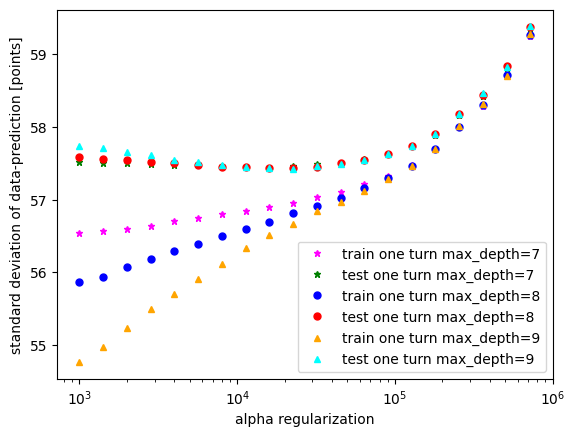

In [16]:
plt.plot(resf[0],resf[2],'*',ms=5,color='magenta',label='train one turn max_depth=7') 
plt.plot(resf[0],resf[3],'*',ms=5,color='green',label='test one turn max_depth=7')
plt.plot(resg[0],resg[2],'o',ms=5,color='blue',label='train one turn max_depth=8') 
plt.plot(resg[0],resg[3],'o',ms=5,color='red',label='test one turn max_depth=8') 
plt.plot(resh[0],resh[2],'^',ms=5,color='orange',label='train one turn max_depth=9') 
plt.plot(resh[0],resh[3],'^',ms=5,color='cyan',label='test one turn max_depth=9') 
plt.legend(loc="best")
plt.xscale("log")
#plt.ylim(55,65)
plt.xlabel("alpha regularization")
plt.ylabel("standard deviation of data-prediction [points]")
print(f"The regularization of the best standard deviation is {resh[0,np.argmin(resh[3])]}")

It is visible in the plot and in the numbers that the model with max depth of 9 is slightly better around the minima for 9. I therefore use the parameters of the best depth 7 models and regenerate it below and save it. 

In [10]:


#excute best model
regxl28=XGBRegressor(max_depth=9,reg_alpha=2.25966826e+04).fit(feature_train, target_train)
#and save it
regxl28.save_model("xgb_model2.json")



The model is then is in the game. 

Now I am looking into other models to train because it seems that training on the iteration does not work for the aim because it trains mainly on the algorithm.

First deep learning. 

In [9]:
feature_train=feature_train.to_numpy()
feature_test=feature_test.to_numpy()
target_train=target_train.to_numpy()
target_test=target_test.to_numpy()

In [10]:
#tensor flow does not work 
model_dl2 = Sequential(
    [              
        tf.keras.Input(shape=(30,)),   
        Dense(15, activation="relu", name="layer1"),
        Dense(5, activation="relu", name="layer2"),        
        Dense(1, activation="linear", name="layer3"),
    ], name = "model1"
) 

2023-03-02 11:01:12.789942: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-02 11:01:12.789991: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-02 11:01:12.790029: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tobias-E15301): /proc/driver/nvidia/version does not exist
2023-03-02 11:01:12.791796: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
#get avg_value
weight_vec=np.array([5/150,10/150,15/150,10/150,10/150,10/150,10/150,10/150,10/150,10/150,10/150,10/150,10/150,10/150,10/150]) 
vals=np.array(range(-2,13))
print(vals)
av_value=np.dot(vals,weight_vec)
print(av_value)
df['own_n_closed']=df.loc[:,'own_cards_0':'own_cards_11'][df.loc[:,'own_cards_0':'own_cards_11']==20].count(axis=1)
#now n_open isstead because small n_vanished likely cases pron=blem in deep learning
df['own_n_open']=df.loc[:,'own_cards_0':'own_cards_11'][(df.loc[:,'own_cards_0':'own_cards_11']!=30) & (df.loc[:,'own_cards_0':'own_cards_11']!=20)].count(axis=1)
df['own_max']=df.loc[:,'own_cards_0':'own_cards_11'][(df.loc[:,'own_cards_0':'own_cards_11']!=20) & (df.loc[:,'own_cards_0':'own_cards_11']!=30)].max(axis=1)
df['own_sum']=df.loc[:,'own_cards_0':'own_cards_11'][(df.loc[:,'own_cards_0':'own_cards_11']!=20) & (df.loc[:,'own_cards_0':'own_cards_11']!=30)].sum(axis=1)
df['other_player_n_closed']=df.loc[:,'other_player_cards_0':'other_player_cards_11'][df.loc[:,'other_player_cards_0':'other_player_cards_11']==20].count(axis=1)
df['other_player_n_open']=df.loc[:,'other_player_cards_0':'other_player_cards_11'][(df.loc[:,'other_player_cards_0':'other_player_cards_11']!=20) & (df.loc[:,'other_player_cards_0':'other_player_cards_11']!=30)].count(axis=1)
df['other_player_max']=df.loc[:,'other_player_cards_0':'other_player_cards_11'][(df.loc[:,'other_player_cards_0':'other_player_cards_11']!=20) & (df.loc[:,'other_player_cards_0':'other_player_cards_11']!=30)].max(axis=1)
df['other_player_sum']=df.loc[:,'other_player_cards_0':'other_player_cards_11'][(df.loc[:,'other_player_cards_0':'other_player_cards_11']!=20) & (df.loc[:,'other_player_cards_0':'other_player_cards_11']!=30)].sum(axis=1)
#replace placeholder with for closed with avg_value
df['value_player_card']=df['numeric_player_card']
df.value_player_card[df.numeric_player_card==20]=av_value
print(df.head())
print(df.columns)
#print(df.describe())
print(max(df.numeric_player_card),max(df.value_player_card))

[-2 -1  0  1  2  3  4  5  6  7  8  9 10 11 12]
5.066666666666666


/tmp/ipykernel_18493/565784260.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.value_player_card[df.numeric_player_card==20]=av_value


   open_pile_card  own_cards_0  own_cards_1  own_cards_2  own_cards_3  \
0              -2           20            7           20           20   
1               0           -2            1            1           11   
2              -1           20           20           20           20   
3              11           11           -2            0           20   
4               4           -1            0            3            0   

   own_cards_4  own_cards_5  own_cards_6  own_cards_7  own_cards_8  ...  \
0            5           20            2           20            8  ...   
1            2           20           -1            6            7  ...   
2           20           20           20            0           20  ...   
3           20            8           -1           20           12  ...   
4            5           20           20            4            0  ...   

   round  own_n_closed  own_n_open  own_max  own_sum  other_player_n_closed  \
0      0             6         

In [26]:
newcolumns=['open_pile_card', 'own_n_closed', 'own_n_open', 'own_max',
       'own_sum', 'other_player_n_closed', 'other_player_n_open',
       'other_player_max', 'other_player_sum', 'action_take_open', 'action_discard',
       'discard_value','numeric_player_card', 'score_self',
       'score_other', 'round']

In [12]:
df2=df.loc[:,newcolumns]
print(df2.columns)
print(df2.head())
print(df2.shape)
df=0


Index(['open_pile_card', 'own_n_closed', 'own_n_open', 'own_max', 'own_sum',
       'other_player_n_closed', 'other_player_n_open', 'other_player_max',
       'other_player_sum', 'action_take_open', 'action_discard',
       'discard_value', 'numeric_player_card', 'score_self', 'score_other',
       'round'],
      dtype='object')
   open_pile_card  own_n_closed  own_n_open  own_max  own_sum  \
0              -2             6           6     10.0     31.0   
1               0             1          11     11.0     36.0   
2              -1            10           2      2.0      2.0   
3              11             5           7     12.0     38.0   
4               4             2          10      9.0     28.0   

   other_player_n_closed  other_player_n_open  other_player_max  \
0                      5                    7              11.0   
1                      4                    8               9.0   
2                      9                    3              12.0   
3        

In [13]:
#split should have been also 0.5 0.8 but difference does not matter much 
feature_train2,feature_test2,feature_valid2, target_train2,target_test2,target_valid2=split_test(df2.iloc[:,0:13],df2.score_self-df2.score_other, df2.iloc[:,15],0.4975,0.796)
print(feature_train2.shape,feature_test2.shape,target_test2.shape,feature_train2.head())

1492500
1492500
2388000
2388000
(1492500, 13) (895500, 13) (895500,)    open_pile_card  own_n_closed  own_n_open  own_max  own_sum  \
0              -2             6           6     10.0     31.0   
1               0             1          11     11.0     36.0   
2              -1            10           2      2.0      2.0   
3              11             5           7     12.0     38.0   
4               4             2          10      9.0     28.0   

   other_player_n_closed  other_player_n_open  other_player_max  \
0                      5                    7              11.0   
1                      4                    8               9.0   
2                      9                    3              12.0   
3                      6                    6              12.0   
4                      1                   11              12.0   

   other_player_sum  action_take_open  action_discard  discard_value  \
0              35.0                 1               0            

In [ ]:
Now running on feature enegering data. 

In [16]:
ar=do_xgb(feature_train2, target_train2, feature_test2, target_test2,6,reg=0)
print(ar)

xgb took 78.0002 seconds
standard deviation of test 64.3463 points
standard deviation of train 64.2901  points
standard deviation of prediction-test 56.5906 points
standard deviation of prediction-train 56.2907 points
[ 0.          6.         56.29072598 56.59058689]


It is clearly better than xgboost on data without feature engering, which achived even after all optimization only a minimum standard deviation of 57.4242.

In [22]:
loop_reg(feature_train2, target_train2, feature_test2, target_test2,5,1000,1.414,20,"xgb_v2en_maxd5.txt")

doing case 0
xgb took 70.2803 seconds
standard deviation of test 64.3463 points
standard deviation of train 64.2901  points
standard deviation of prediction-test 56.578 points
standard deviation of prediction-train 56.4237 points
doing case 1
xgb took 64.8795 seconds
standard deviation of test 64.3463 points
standard deviation of train 64.2901  points
standard deviation of prediction-test 56.5779 points
standard deviation of prediction-train 56.4249 points
doing case 2
xgb took 79.045 seconds
standard deviation of test 64.3463 points
standard deviation of train 64.2901  points
standard deviation of prediction-test 56.5832 points
standard deviation of prediction-train 56.4379 points
doing case 3
xgb took 72.2715 seconds
standard deviation of test 64.3463 points
standard deviation of train 64.2901  points
standard deviation of prediction-test 56.5764 points
standard deviation of prediction-train 56.4419 points
doing case 4
xgb took 72.3702 seconds
standard deviation of test 64.3463 point

In [23]:
resf5=np.loadtxt('xgb_v2en_maxd5.txt')
print(f"minimum standard deviation of (prediction-test data) {round(min(resf5[3]),4)} of max-depth=5")
resf6=np.loadtxt('xgb_v2en_maxd6.txt')
print(f"minimum standard deviation of (prediction-test data) {round(min(resf6[3]),4)} of max-depth=6")
resf7=np.loadtxt('xgb_v2en_maxd7.txt')
print(f"minimum standard deviation of (prediction-test data) {round(min(resf7[3]),4)} of max-depth=7")

minimum standard deviation of (prediction-test data) 56.5764 of max-depth=5
minimum standard deviation of (prediction-test data) 56.5612 of max-depth=6
minimum standard deviation of (prediction-test data) 56.5728 of max-depth=7


The regularization of the best standard deviation is 3997.584364815999


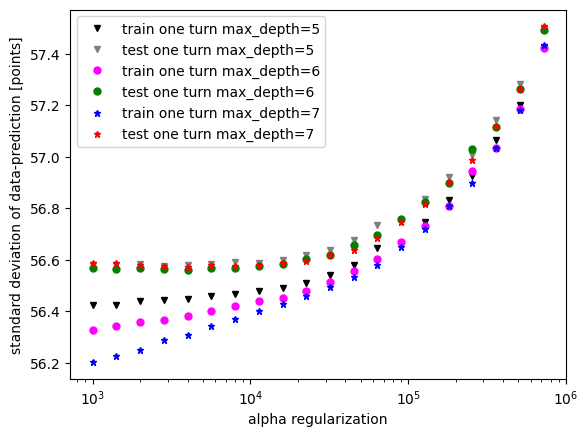

In [24]:
plt.plot(resf5[0],resf5[2],'v',ms=5,color='black',label='train one turn max_depth=5') 
plt.plot(resf5[0],resf5[3],'v',ms=5,color='gray',label='test one turn max_depth=5')
plt.plot(resf6[0],resf6[2],'o',ms=5,color='magenta',label='train one turn max_depth=6') 
plt.plot(resf6[0],resf6[3],'o',ms=5,color='green',label='test one turn max_depth=6')
plt.plot(resf7[0],resf7[2],'*',ms=5,color='blue',label='train one turn max_depth=7') 
plt.plot(resf7[0],resf7[3],'*',ms=5,color='red',label='test one turn max_depth=7')
plt.legend(loc="best")
plt.xscale("log")
#plt.ylim(55,65)
plt.xlabel("alpha regularization")
plt.ylabel("standard deviation of data-prediction [points]")
print(f"The regularization of the best standard deviation is {resf6[0,np.argmin(resf6[3])]}")

In [ ]:
Thus it should be implemented next. 

In [ ]:
regxl29=XGBRegressor(max_depth=6,reg_alpha=3997.584364815999).fit(feature_train2, target_train2)
#and save it
regxl29.save_model("xgb_model1e.json")

In [24]:
regxl29=XGBRegressor()
regxl29.load_model("xgb_model1e.json")

open_pile_card has importance 0.015200000256299973
own_n_closed has importance 0.02239999920129776
own_n_open has importance 0.040300000458955765
own_max has importance 0.0019000000320374966
own_sum has importance 0.31349998712539673
other_player_n_closed has importance 0.049400001764297485
other_player_n_open has importance 0.022700000554323196
other_player_max has importance 0.00139999995008111
other_player_sum has importance 0.3257000148296356
action_take_open has importance 0.08139999955892563
action_discard has importance 0.027400000020861626
discard_value has importance 0.01510000042617321
numeric_player_card has importance 0.0835999995470047


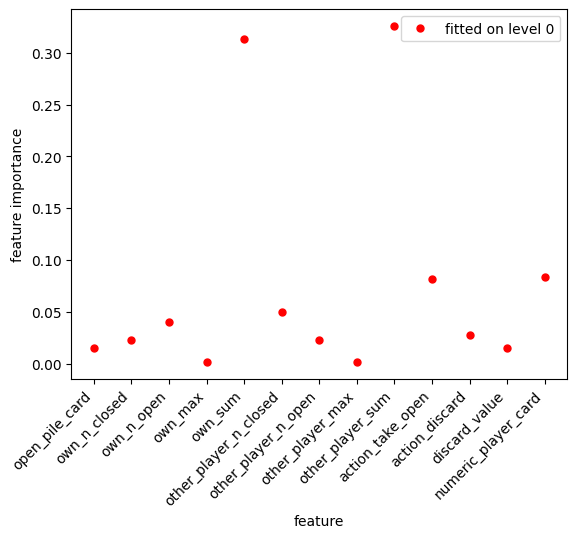

In [27]:
plt.plot(newcolumns[0:13],regxl29.feature_importances_,'o',ms=5,color='red',label='fitted on level 0') 
plt.legend(loc="best")
#plt.xscale("log")
#plt.ylim(55,65)
plt.xticks(rotation=45, ha='right')
plt.xlabel("feature")
plt.ylabel("feature importance")
for i in range(13):
    print(f"{newcolumns[i]} has importance {np.round(regxl29.feature_importances_[i],4)}")


The maximum value has a very small importance, could maybe be omitted for simplicity, the numerical impact should be small since not often relevant. The others have at 1.5% importance. 

Now excluding max value.

In [9]:
weight_vec=np.array([5/150,10/150,15/150,10/150,10/150,10/150,10/150,10/150,10/150,10/150,10/150,10/150,10/150,10/150,10/150]) 
vals=np.array(range(-2,13))
print(vals)
av_value=np.dot(vals,weight_vec)
print(av_value)
df['own_n_closed']=df.loc[:,'own_cards_0':'own_cards_11'][df.loc[:,'own_cards_0':'own_cards_11']==20].count(axis=1)
#now n_open isstead because small n_vanished likely cases pron=blem in deep learning
df['own_n_open']=df.loc[:,'own_cards_0':'own_cards_11'][(df.loc[:,'own_cards_0':'own_cards_11']!=30) & (df.loc[:,'own_cards_0':'own_cards_11']!=20)].count(axis=1)
df['own_sum']=df.loc[:,'own_cards_0':'own_cards_11'][(df.loc[:,'own_cards_0':'own_cards_11']!=20) & (df.loc[:,'own_cards_0':'own_cards_11']!=30)].sum(axis=1)
df['other_player_n_closed']=df.loc[:,'other_player_cards_0':'other_player_cards_11'][df.loc[:,'other_player_cards_0':'other_player_cards_11']==20].count(axis=1)
df['other_player_n_open']=df.loc[:,'other_player_cards_0':'other_player_cards_11'][(df.loc[:,'other_player_cards_0':'other_player_cards_11']!=20) & (df.loc[:,'other_player_cards_0':'other_player_cards_11']!=30)].count(axis=1)

df['other_player_sum']=df.loc[:,'other_player_cards_0':'other_player_cards_11'][(df.loc[:,'other_player_cards_0':'other_player_cards_11']!=20) & (df.loc[:,'other_player_cards_0':'other_player_cards_11']!=30)].sum(axis=1)
#replace placeholder with for closed with avg_value
df['value_player_card']=df['numeric_player_card']
df.value_player_card[df.numeric_player_card==20]=av_value
print(df.head())
print(df.columns)
#print(df.describe())
print(max(df.numeric_player_card),max(df.value_player_card))
newcolumns2=['open_pile_card', 'own_n_closed', 'own_n_open',
       'own_sum', 'other_player_n_closed', 'other_player_n_open','other_player_sum', 'action_take_open', 'action_discard',
       'discard_value','numeric_player_card', 'score_self',
       'score_other', 'round']

[-2 -1  0  1  2  3  4  5  6  7  8  9 10 11 12]
5.066666666666666


/tmp/ipykernel_18493/1291205793.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.value_player_card[df.numeric_player_card==20]=av_value


   open_pile_card  own_cards_0  own_cards_1  own_cards_2  own_cards_3  \
0              -2           20            7           20           20   
1               0           -2            1            1           11   
2              -1           20           20           20           20   
3              11           11           -2            0           20   
4               4           -1            0            3            0   

   own_cards_4  own_cards_5  own_cards_6  own_cards_7  own_cards_8  ...  \
0            5           20            2           20            8  ...   
1            2           20           -1            6            7  ...   
2           20           20           20            0           20  ...   
3           20            8           -1           20           12  ...   
4            5           20           20            4            0  ...   

   round  own_n_closed  own_n_open  own_max  own_sum  other_player_n_closed  \
0      0             6         

In [18]:
df3=df.loc[:,newcolumns2]
print(df3.columns)
print(df3.head())
print(df3.shape)
df=0

Index(['open_pile_card', 'own_n_closed', 'own_n_open', 'own_sum',
       'other_player_n_closed', 'other_player_n_open', 'other_player_sum',
       'action_take_open', 'action_discard', 'discard_value',
       'numeric_player_card', 'score_self', 'score_other', 'round'],
      dtype='object')
   open_pile_card  own_n_closed  own_n_open  own_sum  other_player_n_closed  \
0              -2             6           6     31.0                      5   
1               0             1          11     36.0                      4   
2              -1            10           2      2.0                      9   
3              11             5           7     38.0                      6   
4               4             2          10     28.0                      1   

   other_player_n_open  other_player_sum  action_take_open  action_discard  \
0                    7              35.0                 1               0   
1                    8              30.0                 0               1 

In [19]:
feature_train5,feature_test5,feature_valid5, target_train5,target_test5,target_valid5=split_test(df3.iloc[:,0:11],df3.score_self-df3.score_other, df3.iloc[:,13],0.5,0.8)
print(feature_train5.shape,feature_test5.shape,target_test5.shape,feature_train5.head())

1500000
1500000
2400000
2400000
(1500000, 11) (900000, 11) (900000,)    open_pile_card  own_n_closed  own_n_open  own_sum  other_player_n_closed  \
0              -2             6           6     31.0                      5   
1               0             1          11     36.0                      4   
2              -1            10           2      2.0                      9   
3              11             5           7     38.0                      6   
4               4             2          10     28.0                      1   

   other_player_n_open  other_player_sum  action_take_open  action_discard  \
0                    7              35.0                 1               0   
1                    8              30.0                 0               1   
2                    3              32.0                 0               1   
3                    6              37.0                 0               0   
4                   11              63.0                 0        

In [12]:
ar5=do_xgb(feature_train5, target_train5, feature_test5, target_test5,6,reg=0)
print(ar5)

xgb took 67.4285 seconds
standard deviation of test 64.3409 points
standard deviation of train 64.2938  points
standard deviation of prediction-test 56.5734 points
standard deviation of prediction-train 56.3109 points
[ 0.          6.         56.31091431 56.57338877]


It is slightly better than the previuos before and slightly worse in train, but that very likely overfitting.


In [18]:
loop_reg(feature_train5, target_train5, feature_test5, target_test5,7,1000,1.414,20,"xgb_v2enb_maxd7.txt")

doing case 0
xgb took 75.4494 seconds
standard deviation of test 64.3409 points
standard deviation of train 64.2938  points
standard deviation of prediction-test 56.5705 points
standard deviation of prediction-train 56.2335 points
doing case 1
xgb took 97.9313 seconds
standard deviation of test 64.3409 points
standard deviation of train 64.2938  points
standard deviation of prediction-test 56.5686 points
standard deviation of prediction-train 56.2527 points
doing case 2
xgb took 120.6477 seconds
standard deviation of test 64.3409 points
standard deviation of train 64.2938  points
standard deviation of prediction-test 56.5618 points
standard deviation of prediction-train 56.2718 points
doing case 3
xgb took 106.8096 seconds
standard deviation of test 64.3409 points
standard deviation of train 64.2938  points
standard deviation of prediction-test 56.561 points
standard deviation of prediction-train 56.3076 points
doing case 4
xgb took 107.9401 seconds
standard deviation of test 64.3409 p

In [19]:
resf5=np.loadtxt('xgb_v2enb_maxd5.txt')
print(f"minimum standard deviation of (prediction-test data) {round(min(resf5[3]),4)} of max-depth=5")
resf6=np.loadtxt('xgb_v2enb_maxd6.txt')
print(f"minimum standard deviation of (prediction-test data) {round(min(resf6[3]),4)} of max-depth=6")
resf7=np.loadtxt('xgb_v2en_maxd7.txt')
print(f"minimum standard deviation of (prediction-test data) {round(min(resf7[3]),4)} of max-depth=7")

minimum standard deviation of (prediction-test data) 56.5635 of max-depth=5
minimum standard deviation of (prediction-test data) 56.5501 of max-depth=6
minimum standard deviation of (prediction-test data) 56.5728 of max-depth=7


It is slightly better than before and uses less data, thus it is better. 

The regularization of the best standard deviation is 2827.145944


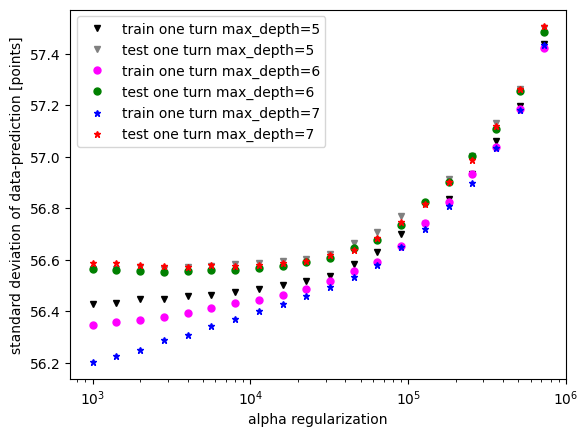

In [20]:
plt.plot(resf5[0],resf5[2],'v',ms=5,color='black',label='train one turn max_depth=5') 
plt.plot(resf5[0],resf5[3],'v',ms=5,color='gray',label='test one turn max_depth=5')
plt.plot(resf6[0],resf6[2],'o',ms=5,color='magenta',label='train one turn max_depth=6') 
plt.plot(resf6[0],resf6[3],'o',ms=5,color='green',label='test one turn max_depth=6')
plt.plot(resf7[0],resf7[2],'*',ms=5,color='blue',label='train one turn max_depth=7') 
plt.plot(resf7[0],resf7[3],'*',ms=5,color='red',label='test one turn max_depth=7')
plt.legend(loc="best")
plt.xscale("log")
#plt.ylim(55,65)
plt.xlabel("alpha regularization")
plt.ylabel("standard deviation of data-prediction [points]")
print(f"The regularization of the best standard deviation is {resf6[0,np.argmin(resf6[3])]}")

In [20]:
regxl30=XGBRegressor(max_depth=6,reg_alpha=2827.145944).fit(feature_train5, target_train5)
#and save it
regxl30.save_model("xgb_model1eb.json")

In [22]:
regxl30=XGBRegressor()
regxl30.load_model("xgb_model1eb.json")

(1500000, 11)
open_pile_card has importance 0.01510000042617321
own_n_closed has importance 0.029899999499320984
own_n_open has importance 0.038600001484155655
own_sum has importance 0.298799991607666
other_player_n_closed has importance 0.052799999713897705
other_player_n_open has importance 0.02710000053048134
other_player_sum has importance 0.3158999979496002
action_take_open has importance 0.08380000293254852
action_discard has importance 0.028999999165534973
discard_value has importance 0.013299999758601189
numeric_player_card has importance 0.09570000320672989
(11,)


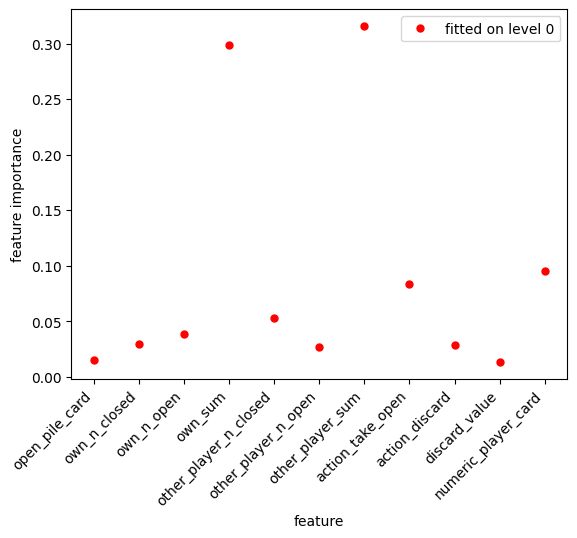

In [23]:
print(feature_train5.shape)
plt.plot(newcolumns2[0:11],regxl30.feature_importances_,'o',ms=5,color='red',label='fitted on level 0') 
plt.legend(loc="best")
#plt.xscale("log")
#plt.ylim(55,65)
plt.xticks(rotation=45, ha='right')
plt.xlabel("feature")
plt.ylabel("feature importance")
for i in range(11):
    print(f"{newcolumns2[i]} has importance {np.round(regxl30.feature_importances_[i],4)}")
print(regxl30.feature_importances_.shape)    

Below I run linear algorithm. The features are partlz changed that no feature with a non linear definition is used.

In [10]:
#for linear model 
newcolumnsl=['open_pile_card', 'own_n_closed', 'own_max',
       'own_sum', 'other_player_n_closed',
       'other_player_max', 'other_player_sum', 'action_take_open', 'action_discard',
       'discard_value','value_player_card', 'score_self',
       'score_other', 'round']
dfl=df.loc[:,newcolumnsl]
print(dfl.columns)
print(dfl.head())
print(dfl.shape)
df=0

Index(['open_pile_card', 'own_n_closed', 'own_max', 'own_sum',
       'other_player_n_closed', 'other_player_max', 'other_player_sum',
       'action_take_open', 'action_discard', 'discard_value',
       'value_player_card', 'score_self', 'score_other', 'round'],
      dtype='object')
   open_pile_card  own_n_closed  own_max  own_sum  other_player_n_closed  \
0              -2             6     10.0     31.0                      5   
1               0             1     11.0     36.0                      4   
2              -1            10      2.0      2.0                      9   
3              11             5     12.0     38.0                      6   
4               4             2      9.0     28.0                      1   

   other_player_max  other_player_sum  action_take_open  action_discard  \
0              11.0              35.0                 1               0   
1               9.0              30.0                 0               1   
2              12.0             

In [17]:
#card value effect of actions, positive is good , discard has no term because in average zero
dfl['all_actions']=dfl.action_take_open*(dfl.open_pile_card-dfl.value_player_card)+(1-dfl.action_take_open)*(1-dfl.action_discard)*(dfl.discard_value-dfl.value_player_card)
dfl.discard_value=dfl.discard_value*(1-dfl.action_take_open)
newcolumnsll=['open_pile_card', 'own_n_closed', 'own_max',
       'own_sum', 'other_player_n_closed',
       'other_player_max', 'other_player_sum','all_actions',
       'discard_value','value_player_card', 'score_self',
       'score_other', 'round']
dfll=dfl.loc[:,newcolumnsll]
print(dfll.columns)
print(dfll.head())
print(dfll.shape)
print(dfl.columns)
print(dfl.action_discard[dfl.value_player_card==av_value])
#dfl=0

Index(['open_pile_card', 'own_n_closed', 'own_max', 'own_sum',
       'other_player_n_closed', 'other_player_max', 'other_player_sum',
       'all_actions', 'discard_value', 'value_player_card', 'score_self',
       'score_other', 'round'],
      dtype='object')
   open_pile_card  own_n_closed  own_max  own_sum  other_player_n_closed  \
0              -2             6     10.0     31.0                      5   
1               0             1     11.0     36.0                      4   
2              -1            10      2.0      2.0                      9   
3              11             5     12.0     38.0                      6   
4               4             2      9.0     28.0                      1   

   other_player_max  other_player_sum  all_actions  discard_value  \
0              11.0              35.0        -10.0              0   
1               9.0              30.0          0.0             12   
2              12.0              32.0          0.0             10   
3   

AttributeError: 'DataFrame' object has no attribute 'action_discard'

In [11]:
feature_train3,feature_test3,feature_valid3, target_train3,target_test3,target_valid3=split_test_valid(dfl.iloc[:,0:10],dfl.score_self-dfl.score_other,0.5,0.8)

AttributeError: 'int' object has no attribute 'iloc'

In [9]:
feature_train4,feature_test4,feature_valid4, target_train4,target_test4,target_valid4=split_test_valid(dfll.iloc[:,0:10],dfll.score_self-dfll.score_other,0.5,0.8)

1500000
2400000


Only all actions amd value_player_card and discard_value matter for finding the best action. Seems not ideal
for choosing action the current difference shoudl also matter since dependent on it the player should finish or not. 

In [26]:
#uses old all actions 
ar3=do_xgb(feature_train3, target_train3, feature_test3, target_test3,6,reg=0)
print(ar3)

xgb took 75.5874 seconds
standard deviation of test 64.3409 points
standard deviation of train 64.2938  points
standard deviation of prediction-test 57.0422 points
standard deviation of prediction-train 56.7833 points
[ 0.          6.         56.78325099 57.04223493]


This without the number of open cards and the average value for closed cards. It is worse than the other two options above and below.

In [10]:
#uses old all actions
#old all_action got 56.5984  56.3039
ar4=do_xgb(feature_train4, target_train4, feature_test4, target_test4,6,reg=0)
print(ar4)

xgb took 76.0936 seconds
standard deviation of test 64.3409 points
standard deviation of train 64.2938  points
standard deviation of prediction-test 56.5894 points
standard deviation of prediction-train 56.284 points
[ 0.          6.         56.28404635 56.58943994]


Using the smallest feature set is a little smaller than the bigger feature enegring but different is very small and selected data is not exactly identical. 

New all actions improves by a very small amount. 

Now linear regression. 

In [8]:
#a few nan problem
#using old all actions
feature_train3[feature_train3.isnull()]=0
feature_test3[feature_test3.isnull()]=0
reg = LinearRegression().fit(feature_train3, target_train3) 
predte= reg.predict(feature_test3)
predtr= reg.predict(feature_train3)
print("less feature enegiering")
print(f"standard deviation of (prediction-test data) {round(np.std(predte-target_test3),4)} of linear regression")
print(f"standard deviation of (prediction-train data) {round(np.std(predtr-target_train3),4)} of linear regression")


less feature enegiering
standard deviation of (prediction-test data) 58.054 of linear regression
standard deviation of (prediction-train data) 58.0262 of linear regression


In [11]:
#a few nan problem
#using new all actions
feature_train4[feature_train4.isnull()]=0
feature_test4[feature_test4.isnull()]=0
reg2 = LinearRegression().fit(feature_train4, target_train4) 
pred2te= reg2.predict(feature_test4)
pred2tr= reg2.predict(feature_train4)
#before was 57.8061 and 57.7652
#with first all_action change 57.7747  57.7329
print("more feature engereing")
print(f"standard deviation of (prediction-test data) {round(np.std(pred2te-target_test4),4)} of linear regression")
print(f"standard deviation of (prediction-train data) {round(np.std(pred2tr-target_train4),4)} of linear regression")

more feature engereing
standard deviation of (prediction-test data) 57.723 of linear regression
standard deviation of (prediction-train data) 57.679 of linear regression


Linear regression is worse than xgboost although it is still a clear improvement. As for xgboost the file where the action is more detailed negored is better although the difference is smaller which means that there is non linearity in the datta which xgboost can model partlz in contrast to linear. 

The better feature engering improves the performance, although not by a lot. Now further improvement. 

-2.0451776252517573
fitting level 0 data with features
open_pile_card has coefficient 0.0201
own_n_closed has coefficient -1.9352
own_max has coefficient -1.4511
own_sum has coefficient 1.6623
other_player_n_closed has coefficient 2.7335
other_player_max has coefficient 1.7904
other_player_sum has coefficient -1.6076
all_actions has coefficient 1.234
discard_value has coefficient 0.1075
value_player_card has coefficient -0.9886


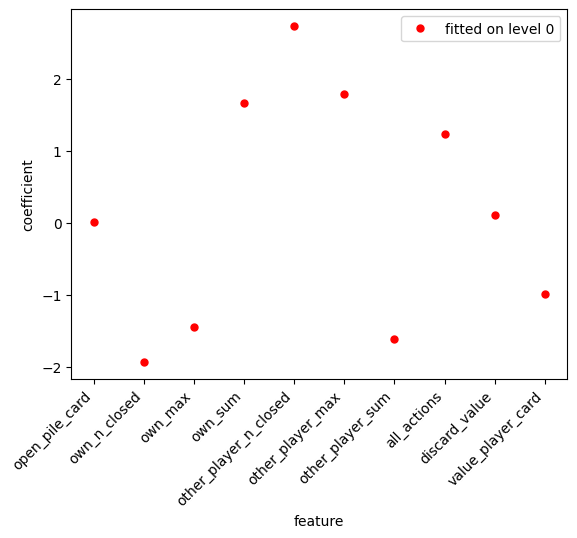

In [12]:
plt.plot(newcolumnsll[0:10],reg2.coef_,'o',ms=5,color='red',label='fitted on level 0') 
plt.legend(loc="best")
#plt.xscale("log")
#plt.ylim(55,65)
plt.xticks(rotation=45, ha='right')
plt.xlabel("feature")
plt.ylabel("coefficient")
print(reg2.intercept_)
print("fitting level 0 data with features")
for i in range(10):
    print(newcolumnsll[i]+" has coefficient "+str(round(reg2.coef_[i],4)))

In [13]:
comb=np.zeros((11))
comb[0]=reg2.intercept_
comb[1:11]=reg2.coef_
print(comb)
np.savetxt('linear_feat_eng0.txt',comb)

[-2.04517763  0.02011113 -1.93515167 -1.45105375  1.66234536  2.73347009
  1.79036821 -1.60755986  1.23402357  0.10749999 -0.98863009]


Other ideas, could look on multiplication combinations between features for linear. First starts with looking on cross correlation coefficient. 

In [14]:
print(dfll.columns)
ser=dfll.open_pile_card*dfll.all_actions
print(ser.shape)

Index(['open_pile_card', 'own_n_closed', 'own_max', 'own_sum',
       'other_player_n_closed', 'other_player_max', 'other_player_sum',
       'all_actions', 'discard_value', 'value_player_card', 'score_self',
       'score_other', 'round'],
      dtype='object')
(3000000,)


In [15]:
print(dfll.columns)
corr1=dfll.iloc[:,0:10].corrwith(dfll.score_self-dfll.score_other)
for i in range(10):
    print(dfll.columns[i])
    print(corr1[i])
#of action time something
print("multiplied")
for i in range(10):
    print(dfll.columns[i])
    ser=dfll.open_pile_card*dfll.iloc[:,i]
    corr2=ser.corr(dfll.score_self-dfll.score_other)
    print(corr2)

Index(['open_pile_card', 'own_n_closed', 'own_max', 'own_sum',
       'other_player_n_closed', 'other_player_max', 'other_player_sum',
       'all_actions', 'discard_value', 'value_player_card', 'score_self',
       'score_other', 'round'],
      dtype='object')
open_pile_card
0.04086651772989221
own_n_closed
-0.035790160782069244
own_max
0.1013995221579601
own_sum
0.18749955847243283
other_player_n_closed
0.0731324617244184
other_player_max
-0.11662345858377392
other_player_sum
-0.22826062334034822
all_actions
0.07415434069615431
discard_value
0.02996778689831143
value_player_card
-0.027635557168330906
multiplied
open_pile_card
0.038752173158218425
own_n_closed
0.007320665119509715
own_max
0.06477769660060997
own_sum
0.1264081107184958
other_player_n_closed
0.06183473239033787
other_player_max
0.012368589407578123
other_player_sum
-0.06945827343851217
all_actions
0.04828286553454652
discard_value
0.02129542843253267
value_player_card
0.017777383243318505


In [10]:
print(dfll.columns)
dfll['n_closed_diff']=dfll['own_n_closed']-dfll['other_player_n_closed']
dfll['current_score_diff']=dfll['own_sum']-dfll['other_player_sum']
dfll['fin_score_diff']=dfll['score_self']-dfll['score_other']
# to be used also'all_actions','discard_value'
dfl2=dfll.loc[:,['n_closed_diff','current_score_diff','all_actions','fin_score_diff']]
print(dfl2.head())

Index(['open_pile_card', 'own_n_closed', 'own_max', 'own_sum',
       'other_player_n_closed', 'other_player_max', 'other_player_sum',
       'all_actions', 'discard_value', 'value_player_card', 'score_self',
       'score_other', 'round'],
      dtype='object')
   n_closed_diff  current_score_diff  all_actions  fin_score_diff
0              1                -4.0        -10.0              13
1             -3                 6.0          0.0             -12
2              1               -30.0          0.0              82
3             -1                 1.0         -4.0              98
4              1               -35.0          0.0             -18


In [22]:
feature_train6,feature_test6,feature_valid6, target_train6,target_test6,target_valid6=split_test_valid(dfl2.iloc[:,0:3],dfl2.iloc[:,3],0.5,0.8)

1500000
2400000


In [25]:
#uses old all_actions had 57.4958 57.3317
#with discard_value  57.525  57.3567
ar6=do_xgb(feature_train6, target_train6, feature_test6, target_test6,6,reg=0)
print(ar6)

xgb took 35.4214 seconds
standard deviation of test 64.3409 points
standard deviation of train 64.2938  points
standard deviation of prediction-test 57.54 points
standard deviation of prediction-train 57.4017 points
[ 0.          6.         57.40168078 57.53997488]


Still rather good, but should it not amtter with the own card is closed or not. Is l;ess good than previous attempt.

In [24]:
feature_train6[feature_train6.isnull()]=0
feature_test6[feature_test6.isnull()]=0
reg3 = LinearRegression().fit(feature_train6, target_train6) 
pred3te= reg3.predict(feature_test6)
pred3tr= reg3.predict(feature_train6)
#previous all_action was 57.9661 57.931
#now with dicard_value 57.893 57.8557
print("more feature engereing")
print(f"standard deviation of (prediction-test data) {round(np.std(pred3te-target_test6),4)} of linear regression")
print(f"standard deviation of (prediction-train data) {round(np.std(pred3tr-target_train6),4)} of linear regression")

(1500000, 3)
more feature engereing
standard deviation of (prediction-test data) 57.893 of linear regression
standard deviation of (prediction-train data) 57.8557 of linear regression


Difference to xgboost is now smaller, linear is in between the two past cases, closer to worse one but not really bad. 

Linear improves with the improved all_action while for xgboost it is not the case, i assume because that has now more problems to find the non linear relations. Same results without discard_value, thus omitted. 

Still worse than above with more features, but the assumption is that is does influence the card selection thus still tried this one.

Now number of closed cards separately. 

In [11]:

dfl3=dfll.loc[:,['own_n_closed','other_player_n_closed','current_score_diff','all_actions','fin_score_diff']]
print(dfl3.head(),dfl3.shape)

   own_n_closed  other_player_n_closed  current_score_diff  all_actions  \
0             6                      5                -4.0        -10.0   
1             1                      4                 6.0          0.0   
2            10                      9               -30.0          0.0   
3             5                      6                 1.0         -4.0   
4             2                      1               -35.0          0.0   

   fin_score_diff  
0              13  
1             -12  
2              82  
3              98  
4             -18   (3000000, 5)


In [31]:
feature_train7,feature_test7,feature_valid7, target_train7,target_test7,target_valid7=split_test_valid(dfl3.iloc[:,0:4],dfl3.iloc[:,4],0.5,0.8)
print(dfl3.all_actions.describe())
#all actions has now many zeros more is natural because now discard is nothing 
print(dfl3.all_actions.quantile([0.1,0.23,0.77,0.9]))

1500000
2400000
count    3.000000e+06
mean    -3.057200e-03
std      4.572956e+00
min     -1.400000e+01
25%     -3.000000e+00
50%      0.000000e+00
75%      2.933333e+00
max      1.400000e+01
Name: all_actions, dtype: float64
0.10   -6.000000
0.23   -3.066667
0.77    3.000000
0.90    6.000000
Name: all_actions, dtype: float64


In [32]:
#before updated all_action and with discard_value it was 56.6243 and 56.4133
#wo discrad value it was  57.0015 and 56.8403
#new with discard value 56.6622 and 56.4538
#new wo discrad value 56.6794 and 56.4958
ar7=do_xgb(feature_train7, target_train7, feature_test7, target_test7,6,reg=0)
print(ar7)

xgb took 40.5272 seconds
standard deviation of test 64.3409 points
standard deviation of train 64.2938  points
standard deviation of prediction-test 56.6794 points
standard deviation of prediction-train 56.4958 points
[ 0.          6.         56.49581069 56.67941652]


Clearly improves for xgboost. Only a little worse than the best before which was 56.5734 in first attempt and 56.5501 in grid search. 

Withn updated all_action and without discrad_value it is clearly worse, here, but the main aim is linear below. Adding discard_action back in improves slighly but still much worse than previous action definition. 

In [33]:
feature_train7[feature_train7.isnull()]=0
feature_test7[feature_test7.isnull()]=0
reg4 = LinearRegression().fit(feature_train7, target_train7) 
pred4te= reg4.predict(feature_test7)
pred4tr= reg4.predict(feature_train7)
#with old all_action and with discard_value it was 57.9562 57.9207
#wo discrad value it was 58.0363 58.0004
#new  (discard does not matter) is clearly better 57.8831 57.8454
print("more feature engereing")
print(f"standard deviation of (prediction-test data) {round(np.std(pred4te-target_test7),4)} of linear regression")
print(f"standard deviation of (prediction-train data) {round(np.std(pred4tr-target_train7),4)} of linear regression")

more feature engereing
standard deviation of (prediction-test data) 57.8831 of linear regression
standard deviation of (prediction-train data) 57.8454 of linear regression


Discard value does not help for linear, thus it is omitted. 

Linear regression is now clearly worse means that there is non linearity which should be explored.

In [34]:
print(dfl3.columns)
corr1=dfl3.iloc[:,0:4].corrwith(dfll.fin_score_diff)
for i in range(4):
    print(dfl3.columns[i])
    print(corr1[i])
#of action time something
print("multiplied")
for i in range(4):
    print(dfl3.columns[i])
    ser=dfl3.all_actions*dfl3.iloc[:,i]
    corr2=ser.corr(dfl3.fin_score_diff)
    print(corr2)

Index(['own_n_closed', 'other_player_n_closed', 'current_score_diff',
       'all_actions', 'fin_score_diff'],
      dtype='object')
own_n_closed
-0.035790160782069244
other_player_n_closed
0.0731324617244184
current_score_diff
0.4183026793862255
all_actions
0.07415434069615431
multiplied
own_n_closed
0.05372483511241383
other_player_n_closed
0.05276005333974508
current_score_diff
0.002845719978508896
all_actions
-0.027988309870638776


In [12]:
dfl3['own_ncl_action']=dfl3['own_n_closed']*dfl3['all_actions']
dfl3['other_ncl_action']=dfl3['other_player_n_closed']*dfl3['all_actions']
dfl3['score_diff_action']=dfl3['current_score_diff']*dfl3['all_actions']
dfl3['squared_action']=dfl3['all_actions']*dfl3['all_actions']

In [13]:
print(dfl3.columns)
neworder=['own_n_closed', 'other_player_n_closed', 'current_score_diff',
       'all_actions', 'own_ncl_action',
       'other_ncl_action', 'squared_action','fin_score_diff']
dfl3=dfl3.loc[:,neworder]
print(dfl3.columns)

Index(['own_n_closed', 'other_player_n_closed', 'current_score_diff',
       'all_actions', 'fin_score_diff', 'own_ncl_action', 'other_ncl_action',
       'score_diff_action', 'squared_action'],
      dtype='object')
Index(['own_n_closed', 'other_player_n_closed', 'current_score_diff',
       'all_actions', 'own_ncl_action', 'other_ncl_action', 'squared_action',
       'fin_score_diff'],
      dtype='object')


In [14]:
print(dfl3.shape)

(3000000, 8)


In [17]:
feature_train8,feature_test8,feature_valid8, target_train8,target_test8,target_valid8=split_test_valid(dfl3.iloc[:,0:7],dfl3.iloc[:,7],0.5,0.8)
print(feature_train8.head(),target_train8.head())

1500000
2400000
   own_n_closed  other_player_n_closed  current_score_diff  all_actions  \
0             6                      5                -4.0        -10.0   
1             1                      4                 6.0          0.0   
2            10                      9               -30.0          0.0   
3             5                      6                 1.0         -4.0   
4             2                      1               -35.0          0.0   

   own_ncl_action  other_ncl_action  squared_action  
0           -60.0             -50.0           100.0  
1             0.0               0.0             0.0  
2             0.0               0.0             0.0  
3           -20.0             -24.0            16.0  
4             0.0               0.0             0.0   0    13
1   -12
2    82
3    98
4   -18
Name: fin_score_diff, dtype: int64


In [18]:
feature_train8[feature_train8.isnull()]=0
feature_test8[feature_test8.isnull()]=0
reg5 = LinearRegression().fit(feature_train8, target_train8) 
pred5te= reg5.predict(feature_test8)
pred5tr= reg5.predict(feature_train8)
print("more feature engereing")
#with all test is 57.9049, omit now score_diff_action very small impact, thus not more omitted 
#now better all_actions 57.8195
print(f"standard deviation of (prediction-test data) {round(np.std(pred5te-target_test8),4)} of linear regression")
print(f"standard deviation of (prediction-train data) {round(np.std(pred5tr-target_train8),4)} of linear regression")

more feature engereing
standard deviation of (prediction-test data) 57.8195 of linear regression
standard deviation of (prediction-train data) 57.7736 of linear regression


Not much overfitting since mkeasure very similar for test and train. The improvement compared to only linear is small. It is still worse than xgboost, but that is understandable, since since here I concentrate on features which has an impact on actions.
Due to the non linearity of xgboost there less cleaning is easier, here the opposite is the case.

Linear was 57.8831 57.8454, thus there is a clear improvement by adding quadratic features. 


2.386411893914033
fitting level 0 data with features
own_n_closed has coefficient -2.4775
other_player_n_closed has coefficient 2.8141
current_score_diff has coefficient 1.4768
all_actions has coefficient 2.3584
own_ncl_action has coefficient -0.1181
other_ncl_action has coefficient -0.0457
squared_action has coefficient -0.0656


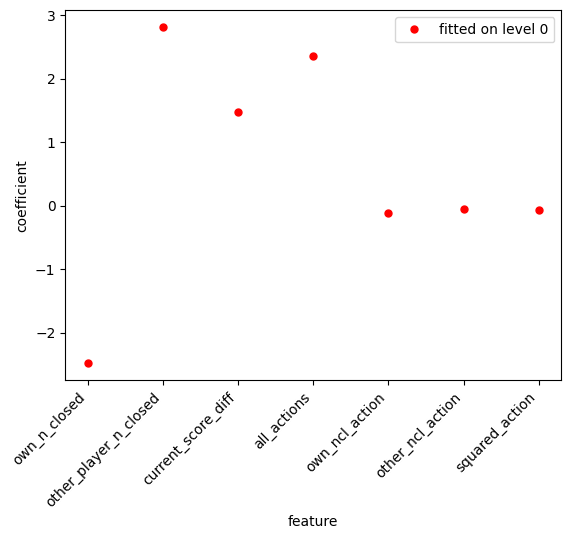

In [20]:
plt.plot(neworder[0:7],reg5.coef_,'o',ms=5,color='red',label='fitted on level 0') 
plt.legend(loc="best")
#plt.xscale("log")
#plt.ylim(55,65)
plt.xticks(rotation=45, ha='right')
plt.xlabel("feature")
plt.ylabel("coefficient")
print(reg5.intercept_)
print("fitting level 0 data with features")
for i in range(7):
    print(neworder[i]+" has coefficient "+str(round(reg5.coef_[i],4)))

fitting level 0 data with features
own_n_closed has coefficient/scatter -0.0514
other_player_n_closed has coefficient/scatter 1.2459
current_score_diff has coefficient/scatter 0.1198
all_actions has coefficient/scatter 0.1763
own_ncl_action has coefficient/scatter -0.0095
other_ncl_action has coefficient/scatter -0.0031
squared_action has coefficient/scatter -0.0068


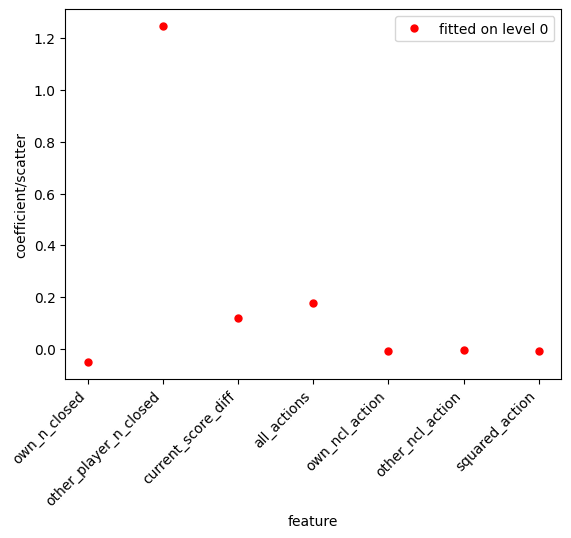

In [21]:
res=np.zeros((7))
for i in range(7):
    res[i]=reg5.coef_[i]/np.std(feature_train8.iloc[i,:])
plt.plot(neworder[0:7],res,'o',ms=5,color='red',label='fitted on level 0') 
plt.legend(loc="best")
#plt.xscale("log")
#plt.ylim(55,65)
plt.xticks(rotation=45, ha='right')
plt.xlabel("feature")
plt.ylabel("coefficient/scatter")
print("fitting level 0 data with features")
for i in range(7):
    print(neworder[i]+" has coefficient/scatter "+str(round(res[i],4)))

In [22]:
comb=np.zeros((8))
comb[0]=reg5.intercept_
comb[1:8]=reg5.coef_
print(comb)
np.savetxt('linear_feat_eng1.txt',comb)
#save the model that can applied easily when sklearn is available
pickle.dump(reg5, open('linear_feat_eng1.pkl', 'wb'))
#loaded_model = pickle.load(open('linear_feat_eng1.pkl', 'rb'))
print(neworder)
for i in range(23,31):
    print(i)
    print(columns[i])
print(columns[0])    

[ 2.38641189 -2.4774963   2.81412738  1.47682029  2.35840823 -0.11812912
 -0.04572112 -0.06558562]
['own_n_closed', 'other_player_n_closed', 'current_score_diff', 'all_actions', 'own_ncl_action', 'other_ncl_action', 'squared_action', 'fin_score_diff']
23
other_player_cards_10
24
other_player_cards_11
25
action_take_open
26
action_discard
27
discard_value
28
id_player_card
29
numeric_player_card
30
score_self
open_pile_card


For a different method, I could look on different options , make to runs of the same but make two version on one action acting different to compare the effect.  Not so easy for random algorithm easier on other since it easier to predict, still totally predictable leads to the knowns problems also, but probably o.k. when it is not exactly the same after the split. Would need some changes to be able to run. Exaxtley once a two split is also difficult to implement since length is not known a priori, but the last one is always known before, and it can be done there when it do not yet happenend before. 

Still not clear that it is good to implement new methods. 